# Ignis - Aer density matrix calculations

Hi, let me recap and share the code.

A single Rx(theta) is considered (written in terms of U3).

1. Calculation of density matrix on real HW with Ignis Tomography -> affected by HW errors
2. Calculation of theoric (using vectors and matrices math calculations) density matrix = |psi_final><psi_final| -> exact
3. Calculation of density matrix on Aer simulator considering gate errors modelization (coherent errors) and simulated HW errors readout_error, depolarization_error, thermal_relaxation_error (incoherent)

For the Aer errors parametrizations, I followed this tutorial: 
https://quantum-computing.ibm.com/jupyter/tutorial/advanced/aer/3_building_noise_models.ipynb

and I used T1 and T2 listed on chip calibration. 

### Expected behaviour: density matrix 1 similar to density matrix 3, some differences with density matrix 2 (because it is exact, without errors).

### Found behaviour: when enabling both thermal and depolariz errors, Real and Imaginary part of density matrix are inverted respect to theoric calculation and real HW Ignis Tomography results.

#### You can change incoherent errors enabled in "Density matrix Aer noisy simulation with generalized U(eps)" cell, on lines:

In [ ]:
#TRY SETTING 1-0 OR 0-1
#thermal = 1
#depolariz = 0

## Code

In [1]:
# MODULE IMPORT
%matplotlib inline

# Standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer, IBMQ, BasicAer
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter
from qiskit.transpiler import PassManager
import math, numpy as np, scipy, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

initialization = ""

## Parameter and circuits definitions

In [2]:
# Parameters
nShots = 8192 # max
hw_backend = 'ibmq_5_yorktown'

# Rotation angle
theta = np.pi*0.3

# PREPARE FOR CLOUD
my_api_token = '359d9c9c5b6a1efc59e40042c9f4b1fe4be830a26ebe42118a1651daac0a7bd8739a64548c525c2fbef276c0c1f2bfe187d908988a0ae6e9de3692be45fb6b8e'
if (initialization != "initialized"):
    provider = IBMQ.enable_account(my_api_token)
    IBMQ.providers()
    initialization = "initialized"
    print('Cloud initialization done')
else : print('Cloud already initialized')

Cloud initialization done


/usr/local/anaconda3/envs/Qiskitenv_v14/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


## 1. Density matrix calculation with Ignis Tomography

In [3]:
# Circuit preparation
     
# Real HW runs: write Rx in terms of generic U3 rotation
c = ClassicalRegister(1,'c')
q = QuantumRegister(1,'q')
tomo = QuantumCircuit(q,c)
tomo.u3(theta,-np.pi/2,np.pi/2,0) #generic Rx(theta) gate

cloud_hw = IBMQ.get_provider().get_backend(hw_backend)

# Create tomography circuits
qst = state_tomography_circuits(tomo, [q[0]])
        
# Run tomography
print('Run on cloud HW '+str(cloud_hw)+' ...')
job_tomo = execute(qst, backend = cloud_hw, shots = nShots)
job_monitor(job_tomo)
tomo = StateTomographyFitter(job_tomo.result(), qst) # Generate tomography
dm = tomo.fit() # Output density matrix
        
print('ALL RUNS DONE.')

Run on cloud HW ibmqx2 ...
Job Status: job has successfully run
ALL RUNS DONE.


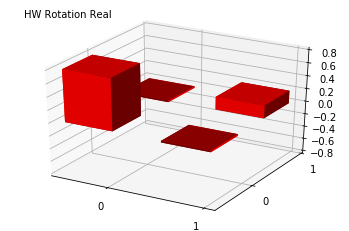

[[ 0.803 -0.023]
 [-0.023  0.197]]


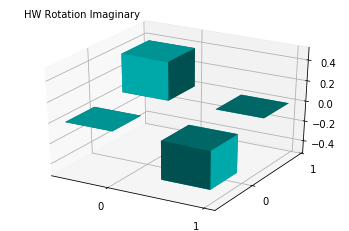

[[ 0.     0.378]
 [-0.378  0.   ]]


In [4]:
## SHOW HW RESULTS ###################################

rho_re = np.real(dm) # Real part
rho_im = np.imag(dm) # Imaginary part

kets = ["0","1"] #my axis labels

# Rotation Real
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
xpos = [range(rho_re.shape[0])]
ypos = [range(rho_re.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
ax.set_zlim3d(-0.8,0.8)
dx = 0.5 * np.ones_like(zpos) # x distance from each bar
dy = dx.copy() # y distance from each bar
dz = rho_re.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average')
ax.text2D(0.05, 0.95, "HW Rotation Real", transform=ax.transAxes)
ax.w_xaxis.set_ticklabels(kets)
ax.w_yaxis.set_ticklabels(kets)
ticksx = np.arange(0.5,2,1)
ticksy = np.arange(0.6,2,1)
plt.xticks(ticksx,kets)
plt.yticks(ticksy,kets)
plt.show()
print(np.around(rho_re,3))

# Rotation Imaginary
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
xpos = [range(rho_im.shape[0])]
ypos = [range(rho_im.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
ax.set_zlim3d(-0.5,0.5)
dx = 0.5 * np.ones_like(zpos) # x distance from each bar
dy = dx.copy() # y distance from each bar
dz = rho_im.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='c', zsort='average')
ax.text2D(0.05, 0.95, "HW Rotation Imaginary", transform=ax.transAxes)
ax.w_xaxis.set_ticklabels(kets)
ax.w_yaxis.set_ticklabels(kets)
ticksx = np.arange(0.5,2,1)
ticksy = np.arange(0.6,2,1)
plt.xticks(ticksx,kets)
plt.yticks(ticksy,kets)
plt.show()
print(np.around(rho_im,3))

## 2. Exact density matrix theoric with |psi><psi|

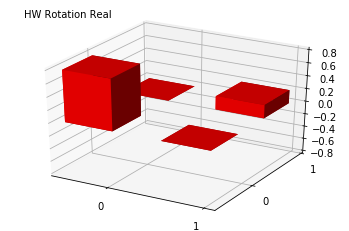

[[0.794 0.   ]
 [0.    0.206]]


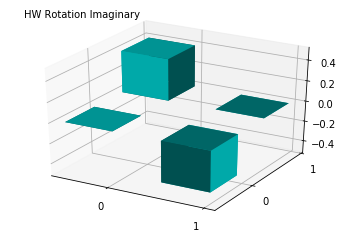

[[ 0.     0.405]
 [-0.405  0.   ]]


In [5]:
# Initial state
init = np.array( ([1],[0]) )

# Theoric rotation (U3)
Rx = np.array( ((np.cos(theta/2),-1j*np.sin(theta/2)),(-1j*np.sin(theta/2),np.cos(theta/2))) )

# Density matrix calculation |psi><psi|
psi = np.dot(Rx,init)
psi_tc = psi.transpose().conj()
rho = np.dot(psi,psi_tc)

# Rho Real and Imaginary parts
rho_re = np.real(rho)
rho_im = np.imag(rho)
        
kets = ["0","1"] #my axis labels

# Rotation Real
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
xpos = [range(rho_re.shape[0])]
ypos = [range(rho_re.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
ax.set_zlim3d(-0.8,0.8)
dx = 0.5 * np.ones_like(zpos) # x distance from each bar
dy = dx.copy() # y distance from each bar
dz = rho_re.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average')
ax.text2D(0.05, 0.95, "HW Rotation Real", transform=ax.transAxes)
ax.w_xaxis.set_ticklabels(kets)
ax.w_yaxis.set_ticklabels(kets)
ticksx = np.arange(0.5,2,1)
ticksy = np.arange(0.6,2,1)
plt.xticks(ticksx,kets)
plt.yticks(ticksy,kets)
plt.show()
print(np.around(rho_re,3))

# Rotation Imaginary
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
xpos = [range(rho_im.shape[0])]
ypos = [range(rho_im.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
ax.set_zlim3d(-0.5,0.5)
dx = 0.5 * np.ones_like(zpos) # x distance from each bar
dy = dx.copy() # y distance from each bar
dz = rho_im.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='c', zsort='average')
ax.text2D(0.05, 0.95, "HW Rotation Imaginary", transform=ax.transAxes)
ax.w_xaxis.set_ticklabels(kets)
ax.w_yaxis.set_ticklabels(kets)
ticksx = np.arange(0.5,2,1)
ticksy = np.arange(0.6,2,1)
plt.xticks(ticksx,kets)
plt.yticks(ticksy,kets)
plt.show()
print(np.around(rho_im,3))

## 3. Density matrix Aer noisy simulation with generalized U(eps)

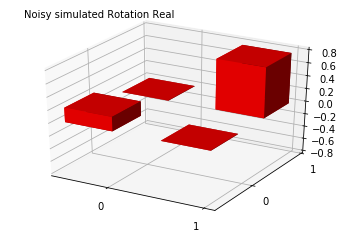

[[0.222 0.004]
 [0.004 0.778]]


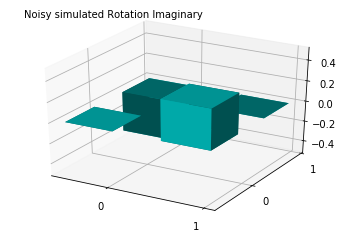

[[ 0.    -0.391]
 [ 0.391  0.   ]]


In [15]:
# TRY SETTING 1-0 OR 0-1
thermal = 1
depolariz = 1

# one of thermal or depolariz must be 1 (do not disable all errors)

# Creation of noise model
noise_total = []
noise_total = NoiseModel()

##################################

# READOUT_ERROR
p0given1 = 0.009
p1given0 = 0.009

# DEPOLARIZING_ERROR
depol = 0.003

# THERMAL_RELAXATION_ERROR
T1s = [64.00*1000,54.00*1000,54.00*1000,55.00*1000,64.00*1000] # T1 in nanoseconds
T2s = [75.00*1000,64.00*1000,62.00*1000,36.00*1000,36.00*1000] # T2 in nanoseconds
time_u1 = 0   # Gate U1 time in nanoseconds - virtual gate
time_u2 = 50  # Gate U2 time in nanoseconds - single X90 pulse
time_u3 = 100 # Gate U3 time in nanoseconds - two X90 pulses
time_cx = 300 # Gate CX time in nanoseconds
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

##################################

readout_err = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
depol_err = depolarizing_error(depol, 1) #u1,u2,u3

errors_reset = [thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)]
#errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             #thermal_relaxation_error(t1b, t2b, time_cx))
              #for t1a, t2a in zip(T1s, T2s)]
              #for t1b, t2b in zip(T1s, T2s)] 

err_u1 = []
err_u2 = []
err_u3 = []

if thermal == 1 and depolariz == 1:
    for i in range(1):
        err_u1.append(depol_err.compose(errors_u1[i]))
        err_u2.append(depol_err.compose(errors_u2[i]))
        err_u3.append(depol_err.compose(errors_u3[i]))
        
if thermal == 0 and depolariz == 1:
    for i in range(1):
        err_u1.append(depol_err)
        err_u2.append(depol_err)
        err_u3.append(depol_err)
        
if thermal == 1 and depolariz == 0:
    for i in range(1):
        err_u1.append(errors_u1[i])
        err_u2.append(errors_u2[i])
        err_u3.append(errors_u3[i])

################################## 

# Add errors to noise model

for j in range(1): # only 1 qubit
    
    noise_total.add_readout_error(readout_err,[j])
        
    noise_total.add_quantum_error(errors_reset[j], 'reset', [j])
    noise_total.add_quantum_error(errors_measure[j], 'measure', [j])
    noise_total.add_quantum_error(err_u1[j], 'u1', [j])
    noise_total.add_quantum_error(err_u2[j], 'u2', [j])
    noise_total.add_quantum_error(err_u3[j], 'u3', [j])

device = IBMQ.get_provider().get_backend(hw_backend)
properties = device.properties()
coupling_map = device.configuration().coupling_map

##################################

# CREATE AND EXECUTE CIRCUITS
c = ClassicalRegister(1,'c')
q = QuantumRegister(1,'q')
            
# Circuit to calculate diagonal elements
dd_idg = QuantumCircuit(q,c)

dd_idg.u3(theta,-np.pi/2,np.pi/2,0)
dd_idg.measure(0,0)
            
            
# Circuit to calculate off diagonal elements (Real)
dd_odg_re = QuantumCircuit(q,c)

dd_odg_re.u3(theta,-np.pi/2,np.pi/2,0)
dd_odg_re.h(0)
dd_odg_re.measure(0,0)
               
            
# Circuit to calculate off diagonal elements (Imaginary)
dd_odg_im = QuantumCircuit(q,c)

dd_odg_im.u3(theta,-np.pi/2,np.pi/2,0)
dd_odg_im.u3(np.pi/2,-np.pi/2,np.pi/2,0) #X_pi/2
dd_odg_im.measure(0,0)


# NOISY SIMULATION
simulator = QasmSimulator()
        

        
# Noisy Aer simulation (eps) in diagonal elements
job_idg = execute(dd_idg,
                    shots = nShots,
                    backend = simulator,
                    coupling_map = coupling_map,
                    basis_gates = noise_total.basis_gates,
                    noise_model = noise_total
                    )
resu_idg = [job_idg.result().get_counts(i) for i in range(len(job_idg.result().results))]
dd_idg = resu_idg[0]

# Noisy Aer simulation (eps) off diagonal Real elements
job_odg_re = execute(dd_odg_re,
                    shots = nShots,
                    backend = simulator,
                    coupling_map = coupling_map,
                    basis_gates = noise_total.basis_gates,
                    noise_model = noise_total
                    )
resu_odg_re = [job_odg_re.result().get_counts(i) for i in range(len(job_odg_re.result().results))]
dd_odg_re = resu_odg_re[0]

# Noisy Aer simulation (eps) off diagonal Imaginary elements
job_odg_im = execute(dd_odg_im,
                    shots = nShots,
                    backend = simulator,
                    coupling_map = coupling_map,
                    basis_gates = noise_total.basis_gates,
                    noise_model = noise_total
                    )
resu_odg_im = [job_odg_im.result().get_counts(i) for i in range(len(job_odg_im.result().results))]
dd_odg_im = resu_odg_im[0]
            

###################################  

# Density matrix calculation
P_0_idg = (dd_idg['0'])/nShots
P_1_idg = (dd_idg['1'])/nShots

P_0_odg_re = (dd_odg_re['0'])/nShots
P_1_odg_re = (dd_odg_re['1'])/nShots
        
P_0_odg_im = (dd_odg_im['0'])/nShots
P_1_odg_im = (dd_odg_im['1'])/nShots
        
# In diagonal elements
a2 = P_0_idg
b2 = P_1_idg

# Off diagonal elements
abS_re = (P_0_odg_re-P_1_odg_re)/2
aSb_re = (P_0_odg_re-P_1_odg_re)/2
abS_im = (P_0_odg_im-P_1_odg_im)/2
aSb_im = -(P_0_odg_im-P_1_odg_im)/2

# Composition density matrix
rho_re = np.array( ((a2,aSb_re),(abS_re,b2)) )
rho_im = np.array( ((0,aSb_im),(abS_im,0)) )


## SHOW NOISY THEORIC RESULTS ###################################

kets = ["0","1"] #my axis labels

# Rotation X Real
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
xpos = [range(rho_re.shape[0])]
ypos = [range(rho_re.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
ax.set_zlim3d(-0.8,0.8)
dx = 0.5 * np.ones_like(zpos) # x distance from each bar
dy = dx.copy() # y distance from each bar
dz = rho_re.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average')
ax.text2D(0.05, 0.95, "Noisy simulated Rotation Real", transform=ax.transAxes)
ax.w_xaxis.set_ticklabels(kets)
ax.w_yaxis.set_ticklabels(kets)
ticksx = np.arange(0.5,2,1)
ticksy = np.arange(0.6,2,1)
plt.xticks(ticksx,kets)
plt.yticks(ticksy,kets)
plt.show()

print(np.around(rho_re,3))

# Rotation X Imaginary
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
xpos = [range(rho_im.shape[0])]
ypos = [range(rho_im.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
ax.set_zlim3d(-0.5,0.5)
dx = 0.5 * np.ones_like(zpos) # x distance from each bar
dy = dx.copy() # y distance from each bar
dz = rho_im.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='c', zsort='average')
ax.text2D(0.05, 0.95, "Noisy simulated Rotation Imaginary", transform=ax.transAxes)
ax.w_xaxis.set_ticklabels(kets)
ax.w_yaxis.set_ticklabels(kets)
ticksx = np.arange(0.5,2,1)
ticksy = np.arange(0.6,2,1)
plt.xticks(ticksx,kets)
plt.yticks(ticksy,kets)
plt.show()

print(np.around(rho_im,3))